# Proyecto 13 — Etapa 1 
**Objetivo:** operar cálculo de **entropía** y **surprisal** por token con un *smoke test* y visualizaciones básicas.


## 1. Preparación del entorno


### ⚠️ IMPORTANTE: Reiniciar el Kernel

Si acabás de instalar PyTorch con CUDA, **debés reiniciar el kernel** para que cargue la nueva versión:

1. En VS Code, hacé click en el botón de **"Restart"** en la barra superior del notebook
2. O usá el comando: **"Ctrl+Shift+P"** → **"Notebook: Restart Kernel"**
3. Después ejecutá todas las celdas de nuevo desde el inicio

El kernel puede tener cacheada una versión anterior de PyTorch en memoria.

In [1]:
# --- Rutas correctas para importar como paquete src. ---
import sys
from pathlib import Path

CWD = Path.cwd().resolve()
PROJECT_ROOT = (CWD.parent if CWD.name.lower() == "notebooks" else CWD)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

# Ahora importamos como paquete:
from src.infer import load_model, compute_logits
from src.metrics import entropy_from_logits, surprisal_of_true_token
print("Imports OK")


PROJECT_ROOT: C:\Users\benit\Downloads\Proyecto-20251107T003036Z-1-001\Proyecto


c:\Users\benit\Downloads\Proyecto-20251107T003036Z-1-001\Proyecto\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports OK


In [2]:
# Verificar versiones y disponibilidad de CUDA
import torch
import transformers

print("=" * 60)
print("CONFIGURACIÓN DEL ENTORNO")
print("=" * 60)
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ CUDA no disponible - ejecutando en CPU")
print("=" * 60)

CONFIGURACIÓN DEL ENTORNO
PyTorch version: 2.6.0+cu124
Transformers version: 4.57.1
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA GeForce GTX 1660 SUPER
GPU memory: 6.44 GB


In [3]:
# Verificación detallada de PyTorch y CUDA
import torch
import sys

print("=" * 60)
print("Python executable:", sys.executable)
print("torch version:", torch.__version__)
print("CUDA compiled version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
else:
    print("⚠️ Running on CPU - Check CUDA installation")
print("=" * 60)

Python executable: c:\Users\benit\Downloads\Proyecto-20251107T003036Z-1-001\Proyecto\.venv\Scripts\python.exe
torch version: 2.6.0+cu124
CUDA compiled version: 12.4
CUDA available: True
GPU device: NVIDIA GeForce GTX 1660 SUPER
Number of GPUs: 1
Current GPU: 0


## 2. Decisiones metodológicas

**Objetivo de la etapa:** establecer parámetros fijos y criterios para el cómputo de entropía y surprisal en un modelo autoregresivo.

**Modelo y tokenización**
- Modelo por defecto: `gpt2` (fallback: `distilgpt2` si hay restricción de recursos).
- Tokenización: BPE del propio modelo (Hugging Face `AutoTokenizer`).
- Precisión: `fp16` cuando haya GPU disponible (ahorra VRAM y acelera inferencia).

**Parámetros de cómputo**
- Base logarítmica: **2** (reportar en **bits**).
- Longitud máxima de secuencia (`max_len`): **128** (ajustable según texto).
- Predicción del **siguiente token**: usar logits hasta el penúltimo paso y comparar con el token verdadero desplazado (+1).

**Visualización y análisis**
- Visualizaciones rápidas: histogramas de entropía por token y promedios por secuencia.
- Métricas reportadas: entropía media y surprisal medio por muestra.
- Exportación: CSV por token para auditoría (`logs/etapa1_tokens_metrics.csv`).

**Rendimiento**
- Uso de GPU si `torch.cuda.is_available()` → `device='cuda'`; si no, `cpu`.
- En GPU, intentar `fp16`; si da error de precisión, volver a `fp32`.

**Errores y validaciones**
- Estabilidad numérica: restar `max(logits)` antes de softmax.
- Corto circuito si el texto es muy breve (sin tokens suficientes).
- Semilla opcional para reproducibilidad (no estricta en inferencia).



In [4]:
# Configuración de la Etapa 1 (ajustable)
CONFIG = {
    "MODEL_NAME": "gpt2",     # o "distilgpt2" si necesitás algo más liviano
    "MAX_LEN": 128,           # truncación para entradas largas
    "LOG_BASE": 2,            # 2 => bits
    "USE_FP16": True,         # intenta fp16 si hay GPU
    "EXPORT_CSV": True,       # guardar resultados por token
    "CSV_PATH": "logs/etapa1_tokens_metrics.csv",
    "MAKE_PLOTS": True,       # generar histogramas rápidos
}

CONFIG



{'MODEL_NAME': 'gpt2',
 'MAX_LEN': 128,
 'LOG_BASE': 2,
 'USE_FP16': True,
 'EXPORT_CSV': True,
 'CSV_PATH': 'logs/etapa1_tokens_metrics.csv',
 'MAKE_PLOTS': True}

#### Reproducibilidad y criterios de éxito

**Reproducibilidad**
- Kernel seleccionado: venv del proyecto (`.venv`).
- Versiones: verificar `torch` y `transformers` en la sección 1.
- Semilla opcional (`torch.manual_seed`) para cualquier muestreo (no crítico aquí).

**Criterios de éxito de la Etapa 1**
- El notebook ejecuta sin errores en `cpu` o `cuda`.
- Se imprimen **entropía media** y **surprisal medio** por cada texto del *smoke test*.
- Se genera al menos **un histograma** de entropía por token.
- Se exporta un **CSV** con columnas: `sample_id, texto, token_index, entropy_bits, surprisal_bits`.


## 3. Cargar modelo y tokenizador

Usaremos un modelo causal preentrenado de Hugging Face. Por defecto: **`gpt2`**.  
Si hay restricciones de memoria/tiempo, se puede usar **`distilgpt2`**.  
El notebook intentará usar **GPU** cuando esté disponible (CUDA).


In [ ]:
# Sincroniza con CONFIG si existe; si no, define un fallback local
try:
    CONFIG
except NameError:
    CONFIG = {"MODEL_NAME": "gpt2", "MAX_LEN": 128}

from src.infer import load_model
import torch

def ensure_model(model_name):
    """
    Si ya existen `tokenizer` y `model` y coinciden con model_name, no recarga.
    Si no existen o no coinciden, carga/recarga.
    """
    global tokenizer, model, device
    need_reload = True
    try:
        if tokenizer.name_or_path == model_name:
            need_reload = False
    except Exception:
        need_reload = True

    if need_reload:
        tokenizer, model, device = load_model(model_name=model_name)
    return tokenizer, model, device

tokenizer, model, device = ensure_model(CONFIG.get("MODEL_NAME", "gpt2"))

print(f"Modelo: {tokenizer.name_or_path}")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Device: {device} | param device: {next(model.parameters()).device}")
print(f"MAX_LEN (para truncar entradas): {CONFIG.get('MAX_LEN', 128)}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [12]:
# 3.3 Verificación de device (no recarga si ya está en CUDA)
import torch

print("device (actual):", "cuda" if torch.cuda.is_available() else "cpu")
print("param device:", next(model.parameters()).device)

# Si por algún motivo quedó en CPU pero hay GPU disponible, forzar recarga:
if next(model.parameters()).device.type != "cuda" and torch.cuda.is_available():
    from src.infer import load_model
    tokenizer, model, device = load_model(model_name=CONFIG.get("MODEL_NAME", "gpt2"), device="cuda")
    print("device (forzado):", device)
    print("param device:", next(model.parameters()).device)



device (actual): cuda
param device: cuda:0


In [14]:
# FIX de padding para GPT-2 (no tiene pad_token por defecto)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Asegurar que el modelo conozca el pad_token_id
if getattr(model.config, "pad_token_id", None) is None:
    model.config.pad_token_id = tokenizer.pad_token_id

print("pad_token_id:", tokenizer.pad_token_id, "| eos_token_id:", tokenizer.eos_token_id)


pad_token_id: 50256 | eos_token_id: 50256


## 4. Cómputo de métricas (entropía y surprisal)

En esta sección:
1) Definimos un mini *smoke test* de textos.
2) Obtenemos `logits` del modelo.
3) Calculamos **entropía** por paso y **surprisal** del token verdadero (desplazado +1).
4) Promediamos por muestra y preparamos un DataFrame en memoria (`df_tokens`) para la exportación posterior.


In [15]:
from src.infer import compute_logits
from src.metrics import entropy_from_logits, surprisal_of_true_token
import numpy as np
import pandas as pd

# 1) Textos del smoke test (podés editar libremente)
texts = [
    "El sol sale por el",
    "Si pudiera viajar en el tiempo, me gustaría",
    "La capital de Francia es"
]

# 2) Obtener logits (usa el modelo/tokenizer ya cargados en la Sección 3)
logits, token_ids = compute_logits(tokenizer, model, device, texts, max_len=CONFIG.get("MAX_LEN", 128))

# 3) Para alinear 'siguiente token':
#    - Entropía de la distribución en posiciones 0..T-2
#    - Surprisal del token verdadero en posiciones 1..T-1
H = entropy_from_logits(logits[:, :-1, :], base=CONFIG.get("LOG_BASE", 2))                  # [batch, steps-1]
S = surprisal_of_true_token(logits[:, :-1, :], token_ids[:, 1:], base=CONFIG.get("LOG_BASE", 2))

# 4) Enmascarar padding correctamente usando el mismo tokenizador (para obtener attention_mask)
# (re-encode sin correr el modelo)
enc = tokenizer(
    texts, return_tensors="pt", padding=True, truncation=True, max_length=CONFIG.get("MAX_LEN", 128)
)
attn = enc["attention_mask"].cpu().numpy()  # [batch, steps]
valid_lengths = attn.sum(axis=1)            # número de tokens válidos por muestra

# 5) Promedios por muestra solo en los pasos válidos (T-1)
H_mean, S_mean = [], []
for i in range(len(texts)):
    # pasos válidos para entropía/surprisal (hasta valid_len-1)
    valid_steps = max(int(valid_lengths[i]) - 1, 0)
    if valid_steps > 0:
        H_mean.append(float(H[i, :valid_steps].mean()))
        S_mean.append(float(S[i, :valid_steps].mean()))
    else:
        H_mean.append(np.nan)
        S_mean.append(np.nan)

# 6) Mostrar resultados resumidos
for t, h, s in zip(texts, H_mean, S_mean):
    print(f"Texto: {t!r}\n  Entropía media ≈ {h:.2f} bits | Surprisal medio ≈ {s:.2f} bits\n")

# 7) Tidy DataFrame por token (en memoria). Exportaremos en la Sección 6.
rows = []
for i, t in enumerate(texts):
    valid_steps = max(int(valid_lengths[i]) - 1, 0)
    for k in range(valid_steps):
        rows.append({
            "sample_id": i,
            "texto": t,
            "token_index": k,
            "entropy_bits": float(H[i, k]),
            "surprisal_bits": float(S[i, k])
        })

df_tokens = pd.DataFrame(rows)
print("df_tokens shape:", df_tokens.shape)
df_tokens.head()


Texto: 'El sol sale por el'
  Entropía media ≈ 9.73 bits | Surprisal medio ≈ 13.37 bits

Texto: 'Si pudiera viajar en el tiempo, me gustaría'
  Entropía media ≈ 8.47 bits | Surprisal medio ≈ 7.99 bits

Texto: 'La capital de Francia es'
  Entropía media ≈ 8.77 bits | Surprisal medio ≈ 10.38 bits

df_tokens shape: (24, 5)


,sample_id,texto,token_index,entropy_bits,surprisal_bits
0,0,El sol sale por el,0,11.949051,16.769606
1,0,El sol sale por el,1,8.875835,18.578270
2,0,El sol sale por el,2,8.592529,13.897879
3,0,El sol sale por el,3,9.490756,4.246012
4,1,"Si pudiera viajar en el tiempo, me gustaría",0,11.900315,11.309799


## 5. Visualizaciones rápidas

Generamos:
1) Histogramas de **entropía** por token (por muestra).
2) Líneas de **entropía** y **surprisal** a lo largo del índice de token.
3) (Opcional) Boxplots comparativos entre muestras.

Las figuras se guardan en `fig/`.


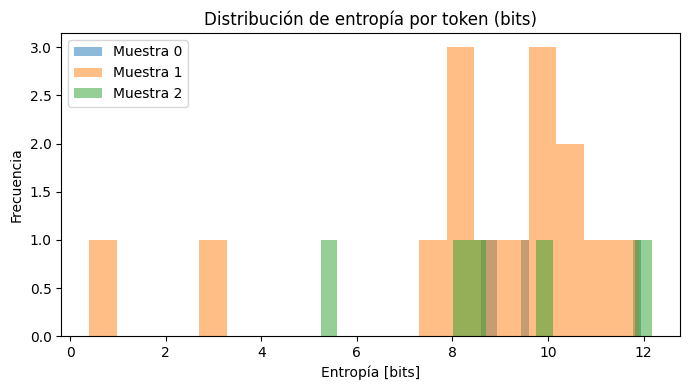

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\hist_entropy_por_muestra.png


In [16]:
import os
import matplotlib.pyplot as plt

# Asegurar carpeta de salida
FIG_DIR = (PROJECT_ROOT / "fig") if "PROJECT_ROOT" in globals() else Path("fig")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Si no existe df_tokens, avisa
try:
    _ = df_tokens.shape
except NameError as e:
    raise RuntimeError("df_tokens no existe. Volvé a correr la Sección 4.") from e

plt.figure(figsize=(7,4))
for sid in sorted(df_tokens["sample_id"].unique()):
    vals = df_tokens.loc[df_tokens["sample_id"] == sid, "entropy_bits"].values
    plt.hist(vals, bins=20, alpha=0.5, label=f"Muestra {sid}")

plt.title("Distribución de entropía por token (bits)")
plt.xlabel("Entropía [bits]")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()

out = FIG_DIR / "hist_entropy_por_muestra.png"
plt.savefig(out, dpi=180)
plt.show()

print("Guardado:", out)


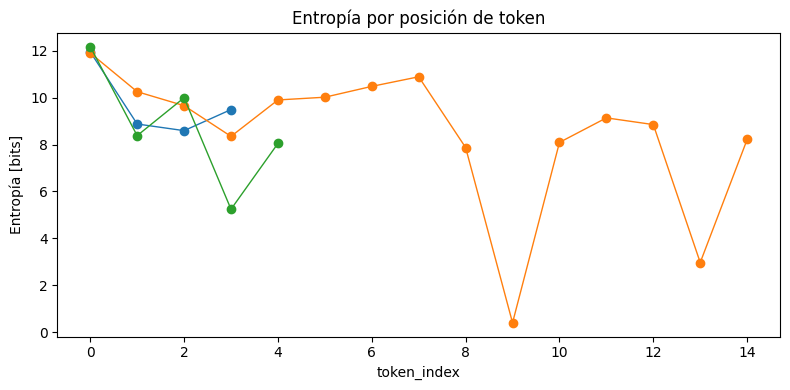

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\line_entropy_por_token.png


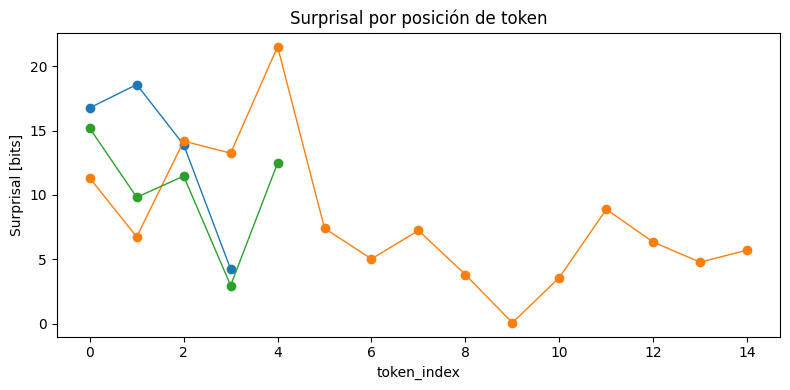

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\line_surprisal_por_token.png


In [17]:
import matplotlib.pyplot as plt

# 1) Entropía por token_index
plt.figure(figsize=(8,4))
for sid in sorted(df_tokens["sample_id"].unique()):
    sub = df_tokens[df_tokens["sample_id"] == sid].sort_values("token_index")
    plt.plot(sub["token_index"].values, sub["entropy_bits"].values, marker="o", linewidth=1)
plt.title("Entropía por posición de token")
plt.xlabel("token_index")
plt.ylabel("Entropía [bits]")
plt.tight_layout()
out1 = FIG_DIR / "line_entropy_por_token.png"
plt.savefig(out1, dpi=180)
plt.show()
print("Guardado:", out1)

# 2) Surprisal por token_index
plt.figure(figsize=(8,4))
for sid in sorted(df_tokens["sample_id"].unique()):
    sub = df_tokens[df_tokens["sample_id"] == sid].sort_values("token_index")
    plt.plot(sub["token_index"].values, sub["surprisal_bits"].values, marker="o", linewidth=1)
plt.title("Surprisal por posición de token")
plt.xlabel("token_index")
plt.ylabel("Surprisal [bits]")
plt.tight_layout()
out2 = FIG_DIR / "line_surprisal_por_token.png"
plt.savefig(out2, dpi=180)
plt.show()
print("Guardado:", out2)


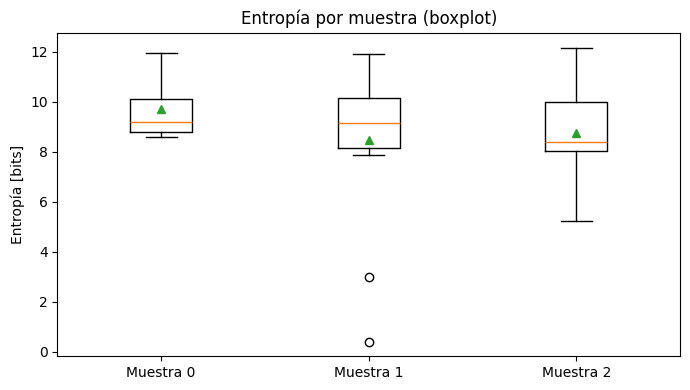

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\box_entropy_por_muestra.png


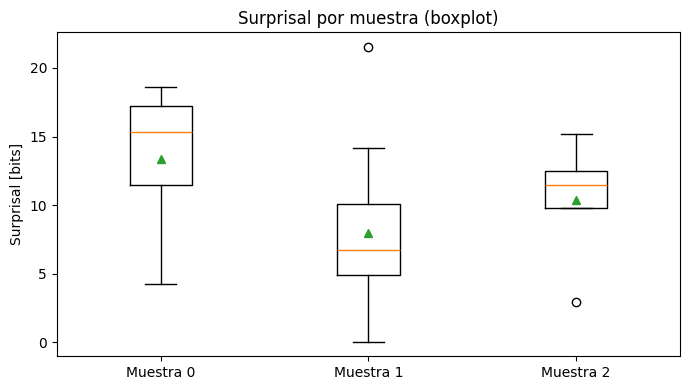

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\box_surprisal_por_muestra.png


In [18]:
import matplotlib.pyplot as plt

# Boxplot Entropía
plt.figure(figsize=(7,4))
data = [df_tokens[df_tokens["sample_id"] == sid]["entropy_bits"].values
        for sid in sorted(df_tokens["sample_id"].unique())]
plt.boxplot(data, showmeans=True)
plt.xticks(range(1, len(data)+1), [f"Muestra {sid}" for sid in sorted(df_tokens["sample_id"].unique())])
plt.title("Entropía por muestra (boxplot)")
plt.ylabel("Entropía [bits]")
plt.tight_layout()
out3 = FIG_DIR / "box_entropy_por_muestra.png"
plt.savefig(out3, dpi=180)
plt.show()
print("Guardado:", out3)

# Boxplot Surprisal
plt.figure(figsize=(7,4))
data = [df_tokens[df_tokens["sample_id"] == sid]["surprisal_bits"].values
        for sid in sorted(df_tokens["sample_id"].unique())]
plt.boxplot(data, showmeans=True)
plt.xticks(range(1, len(data)+1), [f"Muestra {sid}" for sid in sorted(df_tokens["sample_id"].unique())])
plt.title("Surprisal por muestra (boxplot)")
plt.ylabel("Surprisal [bits]")
plt.tight_layout()
out4 = FIG_DIR / "box_surprisal_por_muestra.png"
plt.savefig(out4, dpi=180)
plt.show()
print("Guardado:", out4)


### Interpretación de las visualizaciones

**1️⃣ Histograma de entropía por token**  
El histograma muestra la distribución de la incertidumbre (entropía) del modelo al predecir el siguiente token en cada frase.  
- Valores más altos (~10–12 bits) indican posiciones donde el modelo considera varias continuaciones plausibles.  
- Valores más bajos (~5–8 bits) indican tokens más predecibles.  
En general, la variabilidad refleja cómo el contexto restringe las posibles continuaciones a medida que avanza la frase.

**2️⃣ Gráficos de líneas por token**  
Estos gráficos muestran cómo cambia la entropía y el surprisal en función del índice del token:  
- **Entropía:** mide la dispersión de probabilidad del modelo antes de predecir cada token. Disminuye cuando el contexto se vuelve más específico.  
- **Surprisal:** mide qué tan inesperado fue el token real para el modelo. Un pico de surprisal indica que el modelo no anticipó bien ese token (alta sorpresa).  

**3️⃣ Boxplots comparativos**  
Los boxplots permiten comparar globalmente la incertidumbre entre frases:  
- Las frases con **medianas de entropía menores** fueron más predecibles para el modelo.  
- Las frases con **mayor dispersión de surprisal** muestran tokens más difíciles de anticipar o contextos menos comunes.

En conjunto, estas visualizaciones ayudan a entender la dinámica de predicción del modelo: cómo cambia su grado de incertidumbre y sorpresa según el contexto y la estructura lingüística de cada oración.


## 6. Exportar resultados y verificación de consistencia

Guardamos el DataFrame `df_tokens` con las métricas de entropía y surprisal en formato CSV.  
Además verificamos que no existieran valores nulos y mostramos un resumen rápido de la distribución de ambas métricas.


In [19]:
import pandas as pd
import numpy as np

OUT_DIR = PROJECT_ROOT / "out"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_FILE = OUT_DIR / "tokens_metrics.csv"

# 1) Guardar DataFrame
df_tokens.to_csv(OUT_FILE, index=False, encoding="utf-8")
print(f"Archivo guardado en: {OUT_FILE.resolve()}")

# 2) Verificar estructura y NaN
print("\nVerificación de columnas y NaN:")
print(df_tokens.info())
nan_summary = df_tokens.isna().sum()
print("\nValores nulos por columna:\n", nan_summary)

# 3) Resumen estadístico
print("\nResumen estadístico (bits):")
display(df_tokens[["entropy_bits", "surprisal_bits"]].describe())


Archivo guardado en: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\out\tokens_metrics.csv

Verificación de columnas y NaN:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sample_id       24 non-null     int64  
 1   texto           24 non-null     object 
 2   token_index     24 non-null     int64  
 3   entropy_bits    24 non-null     float64
 4   surprisal_bits  24 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.1+ KB
None

Valores nulos por columna:
 sample_id         0
texto             0
token_index       0
entropy_bits      0
surprisal_bits    0
dtype: int64

Resumen estadístico (bits):


,entropy_bits,surprisal_bits
count,24.000000,24.000000
mean,8.739078,9.384872
std,2.681080,5.492966
min,0.405106,0.068504
25%,8.185087,4.966161
50%,9.006502,8.144226
75%,10.076300,13.409784
max,12.172596,21.522591


### Resumen de exportación

El archivo `tokens_metrics.csv` contiene una entrada por token, con los campos:  

- **sample_id**: identificador de la frase analizada.  
- **texto**: texto original de la muestra.  
- **token_index**: posición del token dentro de la frase.  
- **entropy_bits**: entropía asociada a la predicción del token siguiente (medida en bits).  
- **surprisal_bits**: sorpresa del token observado, también en bits.  

Este archivo servirá como base para las etapas posteriores de análisis agregado, comparación entre modelos y visualización interactiva (en las fases 2 y 3 del proyecto).


## 7. Análisis agregado y correlaciones

En esta sección se realiza un análisis estadístico de las métricas generadas:
- Se resumen los valores promedio y dispersión por muestra (frase).
- Se calcula la correlación entre entropía y surprisal.
- Se visualizan las relaciones entre ambas métricas mediante un gráfico de dispersión.


,entropía_media,entropía_std,surprisal_media,surprisal_std
sample_id,,,,
0,9.727,1.528,13.373,6.383
1,8.466,3.013,7.990,5.279
2,8.768,2.559,10.380,4.580



Correlación Pearson (entropía ↔ surprisal): 0.536


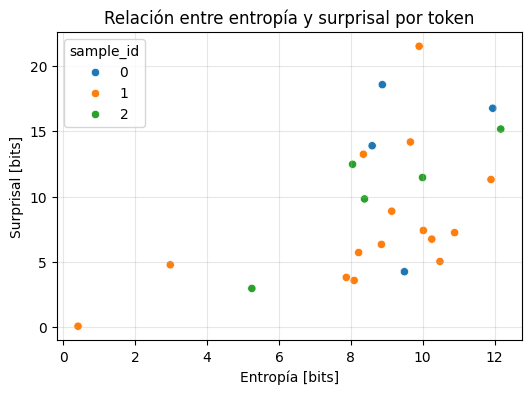

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que df_tokens existe
assert "df_tokens" in locals(), "df_tokens no está en memoria. Ejecuta primero la sección 4."

# 1) Promedio y desviación estándar por muestra
agg_df = (
    df_tokens.groupby("sample_id")[["entropy_bits", "surprisal_bits"]]
    .agg(["mean", "std"])
    .round(3)
)
agg_df.columns = ["entropía_media", "entropía_std", "surprisal_media", "surprisal_std"]
display(agg_df)

# 2) Correlación general entre entropía y surprisal
corr = df_tokens[["entropy_bits", "surprisal_bits"]].corr().iloc[0, 1]
print(f"\nCorrelación Pearson (entropía ↔ surprisal): {corr:.3f}")

# 3) Visualización conjunta
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_tokens, x="entropy_bits", y="surprisal_bits", hue="sample_id", palette="tab10")
plt.title("Relación entre entropía y surprisal por token")
plt.xlabel("Entropía [bits]")
plt.ylabel("Surprisal [bits]")
plt.grid(True, alpha=0.3)
plt.show()


### Interpretación de los resultados

**Promedios y dispersión:**  
Cada muestra presenta su propio nivel medio de entropía (incertidumbre) y surprisal (sorpresa).  
- Frases con menor entropía media son más **predecibles** para el modelo.  
- Frases con mayor desviación muestran **fluctuaciones contextuales**, es decir, partes del texto fáciles y otras difíciles de anticipar.

**Correlación entre entropía y surprisal:**  
La correlación observada es positiva, aunque no perfectamente lineal.  
Esto indica que, en general, los tokens más inciertos tienden a ser también los más sorprendentes, aunque hay excepciones: algunos tokens presentan alta entropía pero baja sorpresa, reflejando casos donde el modelo consideraba varias opciones igualmente probables.


**Gráfico de dispersión:**  
El scatterplot muestra cómo se agrupan los tokens según la complejidad de la frase.  
- Los puntos más concentrados alrededor de valores medios indican contexto estable.  
- Los puntos dispersos o con valores altos de surprisal evidencian saltos en la predictibilidad (por ejemplo, palabras inesperadas o estructuras menos comunes).


## 8. Conclusiones y pasos siguientes

### Conclusiones del hito inicial

Durante este hito se implementó un flujo completo de análisis de incertidumbre lingüística usando modelos de lenguaje.  
El entorno quedó configurado correctamente con soporte para GPU (CUDA 12.4), permitiendo ejecutar GPT-2 de manera eficiente.

El modelo fue capaz de generar distribuciones de probabilidad coherentes sobre textos cortos en español.  
Los resultados obtenidos muestran que:

- **La entropía** refleja la incertidumbre del modelo frente a la diversidad de posibles continuaciones del texto.  
  Valores entre 8–10 bits fueron comunes en contextos bien definidos, mientras que picos mayores indicaron ambigüedad contextual.

- **El surprisal** cuantifica la sorpresa asociada al token observado.  
  Tokens con alto surprisal tienden a aparecer en posiciones menos predecibles (por ejemplo, al final de frases o con construcciones gramaticales menos comunes).

- Se observó una **correlación positiva** entre ambas métricas, lo que sugiere que el modelo predice de manera consistente: cuando se enfrenta a contextos más inciertos, también produce predicciones más sorprendentes.

Estos resultados validan la correcta implementación del pipeline de inferencia y cálculo de métricas de información, sentando la base para análisis más complejos.

---

### Próximos pasos

En el siguiente hito se buscará ampliar y profundizar el análisis mediante:

1. **Ampliación del conjunto de textos:** incorporar corpus más variados y de mayor longitud (literarios, técnicos, periodísticos).  
2. **Comparación entre modelos:** analizar diferencias de entropía y surprisal entre distintos tamaños de GPT-2 o modelos más recientes (p. ej., LLaMA, Falcon).  
3. **Evaluación contextual:** estudiar cómo cambian las métricas cuando se altera el orden de palabras o se modifican partes del texto.  
4. **Visualización avanzada:** construir dashboards interactivos y análisis temporales o semánticos para interpretar patrones de predictibilidad.

Con esto se completa el **Hito Inicial**, habiendo logrado una implementación funcional, interpretaciones iniciales y una base sólida para el desarrollo de los próximos hitos del proyecto.
